In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
train_img_path =os.path.abspath( "../kaggle_whale/train")
test_img_path =os.path.abspath( "../kaggle_whale/test")
train_csv_path = os.path.abspath("../kaggle_whale/train.csv")
submission_csv = "../kaggle_whale/sample_submission.csv"

In [5]:
train_df = pd.read_csv(train_csv_path)
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [7]:
train_df["Image_path"] = [os.path.join(train_img_path,whale) for whale in train_df["Image"]]

In [8]:
train_df.head()

,Image,Id,Image_path
0,0000e88ab.jpg,w_f48451c,../kaggle_whale/train\0000e88ab.jpg
1,0001f9222.jpg,w_c3d896a,../kaggle_whale/train\0001f9222.jpg
2,00029d126.jpg,w_20df2c5,../kaggle_whale/train\00029d126.jpg
3,00050a15a.jpg,new_whale,../kaggle_whale/train\00050a15a.jpg
4,0005c1ef8.jpg,new_whale,../kaggle_whale/train\0005c1ef8.jpg


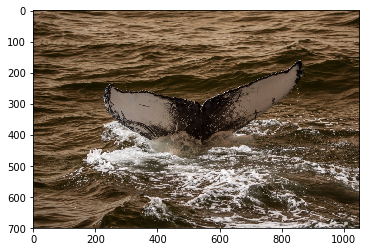

In [10]:
sample_whale = cv2.imread(train_df["Image_path"][0])
plt.imshow(sample_whale)
plt.show()

In [22]:
import keras
import keras.backend as K
from keras.preprocessing import image

In [14]:
datagen = image.ImageDataGenerator(rescale=1./255, validation_split=0.1)
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = datagen.flow_from_dataframe(dataframe=train_df,directory=train_img_path,x_col="Image", y_col="Id", has_ext=True,seed=42,
                                              class_mode="categorical",target_size=(224,224),batch_size=50,subset="training")
valid_generator = datagen.flow_from_dataframe(dataframe=train_df,directory=train_img_path,x_col="Image", y_col="Id", has_ext=True,seed=42,
                                              class_mode="categorical",target_size=(224,224),batch_size=50,subset="validation")
test_generator = datagen.flow_from_directory(directory=test_img_path,seed=42,
                                              class_mode=None,target_size=(224,224),batch_size=1,shuffle=False)


Found 22825 images belonging to 5005 classes.
Found 2536 images belonging to 5005 classes.
Found 0 images belonging to 0 classes.


In [21]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [23]:
from keras.metrics import top_k_categorical_accuracy
def top_5_accuracy(y_true,y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [24]:
from keras.applications import VGG16

In [34]:
vgg16_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [36]:
model = models.Sequential()

In [37]:
model.add(vgg16_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [40]:
from keras import models, layers

In [39]:
model.add(layers.Flatten())
model.add(layers.Dense(1024,activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5005,activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5005)              5130125   
Total params: 45,535,949
Trainable params: 45,535,949
Non-trainable params: 0
_________________________________________________________________


In [41]:
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [42]:
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

In [ ]:
model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, 
                   validation_steps=STEP_SIZE_VALID, epochs=10)

In [ ]:
test_generator.reset()
pred = model.predict_generator(test_generator,verbose = 1,steps=7960)

In [ ]:
pred_sorted = np.argsort(-pred, axis = 1)[:,:5]
pred_sorted

In [47]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [49]:
from tqdm import tqdm
#create empty list
pred_ids = list()
for i,row in enumerate(tqdm(pred_sorted)):
    #create a temporary list to store the ids for a given image
    temp_list = []
    for j,value in enumerate(row):
        #for each index in pred_sorted, append the real Id in temp_list
        temp_list.append(labels[row[j]])
    #append all 5 ids for a given image to pred_ids
    #effectively creating a similar list to pred_sorted
    #but with the real ids
    pred_ids.append(temp_list)

NameError: name 'pred_sorted' is not defined

In [ ]:
final_preds = []
for i,top_5_ids in enumerate(pred_ids):
    final_preds.append(' '.join(pred_ids[i]))

In [ ]:
submission = pd.DataFrame({"Image": os.listdir('../kaggle_whale/test'), "Id": final_preds})
submission.to_csv("submission.csv", index = False)
submission.head()